In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
    
import openpyxl

from scipy import stats

In [2]:
df = pd.read_excel("../附件.xlsx", sheet_name="女胎检测数据")

In [ ]:
df.info()

In [ ]:
df.describe()

## 缺失值

In [ ]:
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("存在缺失值的列:")
    print(missing_values[missing_values > 0])

null_rows = df[df['孕妇BMI'].isnull()].index.tolist()
print(f"空值的行号: {null_rows}")

df["孕妇BMI"][null_rows] = df["体重"][null_rows] / (df["身高"][null_rows] * 1.0 / 100)**2



In [ ]:
df_temp = pd.to_datetime(df['末次月经'], format='%Y/%m/%d', errors='coerce')

# 2. 转换为相对于2022-01-01的天数差
reference_date = pd.Timestamp('2022-01-01')
days_diff = (df_temp - reference_date).dt.days

# 中位数填充缺失值
median_days = days_diff.median()
df['末次月经_天数差'] = days_diff.fillna(median_days).astype('int64')

print("末次月经列转换完成")
print(f"转换后示例: {df['末次月经_天数差'].head().tolist()}")

if '染色体的非整倍体' in df.columns and df['染色体的非整倍体'].isnull().sum() > 0:
    # 用None填充
    df['染色体的非整倍体'].fillna('None', inplace=True)
    print("列 '染色体的非整倍体' 用None填充")

In [ ]:
# 1. IVF妊娠列：自然受孕->0, IVF（试管婴儿）->1, IUI（人工授精）->2
if 'IVF妊娠' in df.columns:
    print("IVF妊娠列唯一值:", df['IVF妊娠'].unique())

    # 创建新列
    df['IVF妊娠_编码'] = df['IVF妊娠'].apply(lambda x: 
        0 if x == '自然受孕' 
        else 1 if x == 'IVF（试管婴儿）' 
        else 2 if x == 'IUI（人工授精）' 
        else x
    )
    df['IVF妊娠_编码'] = df['IVF妊娠_编码'].astype('int64')
    print("IVF妊娠列转换完成")

if '检测孕周' in df.columns:
    def convert_gestational_week(week_str):
        try:
            week_str = str(week_str).replace(' ', '')
            if 'w+' in week_str:
                parts = week_str.split('w+')
                weeks = int(parts[0])
                days = int(parts[1]) if parts[1] != '' else 0
                return weeks * 7 + days
            elif week_str.endswith('w'):
                weeks = int(week_str[:-1])
                return weeks * 7
            else:
                return int(float(week_str)) * 7  
        except:
            return np.nan
    
    df['检测孕周_天数'] = df['检测孕周'].apply(convert_gestational_week)
    # 如果有NaN值，使用fillna处理
    if df['检测孕周_天数'].isnull().any():
        df['检测孕周_天数'] = df['检测孕周_天数'].fillna(0).astype('int64')
    else:
        df['检测孕周_天数'] = df['检测孕周_天数'].astype('int64')
    print("检测孕周转天数转换完成")

if '染色体的非整倍体' in df.columns:
    print("染色体的非整倍体列唯一值:", df['染色体的非整倍体'].unique())
    
    df['T13'] = 0
    df['T18'] = 0
    df['T21'] = 0
    
    for idx, value in df['染色体的非整倍体'].items():
        value_str = str(value)
        if 'T13' in value_str:
            df.at[idx, 'T13'] = 1
        if 'T18' in value_str:
            df.at[idx, 'T18'] = 1
        if 'T21' in value_str:
            df.at[idx, 'T21'] = 1
    
    df['T13'] = df['T13'].astype('int64')
    df['T18'] = df['T18'].astype('int64')
    df['T21'] = df['T21'].astype('int64')
    print("染色体的非整倍体列转换完成")

# 4. 怀孕次数列：创建两列
if '怀孕次数' in df.columns and '生产次数' in df.columns:
    print("怀孕次数列唯一值:", df['怀孕次数'].unique())
    
    # 创建怀孕次数（3）列：≥3换成3
    df['怀孕次数（3）'] = df['怀孕次数'].replace('≥3', '3').astype('int64')
    
    # 创建怀孕次数（4）列：≥3换成4
    df['怀孕次数（4）'] = df['怀孕次数'].replace('≥3', '4').astype('int64')
    
    # 创建怀孕失败次数列
    df['怀孕失败次数（3）'] = df['怀孕次数（3）'] - df['生产次数']
    df['怀孕失败次数（4）'] = df['怀孕次数（4）'] - df['生产次数']
    
    df['怀孕失败次数（3）'] = df['怀孕失败次数（3）'].clip(lower=0)
    df['怀孕失败次数（4）'] = df['怀孕失败次数（4）'].clip(lower=0)
    
    print("怀孕次数相关列转换完成")

# 5. 胎儿是否健康列：是->1，否->0
if '胎儿是否健康' in df.columns:
    # 先查看列中的唯一值
    print("胎儿是否健康列唯一值:", df['胎儿是否健康'].unique())
    
    df['胎儿是否健康_编码'] = df['胎儿是否健康'].apply(lambda x: 
        1 if x == '是' 
        else 0 if x == '否' 
        else x
    )
    df['胎儿是否健康_编码'] = df['胎儿是否健康_编码'].astype('int64')
    print("胎儿是否健康列转换完成")

# 6. 末次月经列：转换为相对于2022-01-01的天数差
if '末次月经' in df.columns:
    print("处理末次月经列...")
    
    # 转换为日期格式
    df_temp = pd.to_datetime(df['末次月经'], format='%Y/%m/%d', errors='coerce')
    
    # 转换为相对于2022-01-01的天数差
    reference_date = pd.Timestamp('2022-01-01')
    days_diff = (df_temp - reference_date).dt.days
    
    # 计算天数差的中位数用于填充缺失值
    median_days = days_diff.median()
    print(f"天数差中位数: {median_days} 天")
    
    # 用中位数填充缺失值并转换为整数
    df['末次月经_天数差'] = days_diff.fillna(median_days).astype('int64')
    
    print("末次月经列转换完成")

print("\n处理后数据类型:")
print(df.dtypes)

# 显示处理结果样本
print("\n处理后的数据样本:")
print(df[['IVF妊娠', 'IVF妊娠_编码', 
          '检测孕周', '检测孕周_天数', 
          '染色体的非整倍体', 'T13', 'T18', 'T21', 
          '怀孕次数', '怀孕次数（3）', '怀孕次数（4）', 
          '生产次数', '怀孕失败次数（3）', '怀孕失败次数（4）',
          '胎儿是否健康', '胎儿是否健康_编码',
          '末次月经', '末次月经_天数差']].head())

In [ ]:
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("存在缺失值的列:")
    print(missing_values[missing_values > 0])

## GC异常值判定

In [ ]:
# gc含量异常判定

# 1.（>0.65 或 <0.35）
con = (df['GC含量'] > 0.65) | (df['GC含量'] < 0.35)
con_rows = df[con]

gc_max = df['GC含量'].max()
gc_min = df['GC含量'].min()

print(f"\nGC含量范围: [{gc_min:.6f}, {gc_max:.6f}]")
print(f"异常阈值: <0.35 或 >0.65")
print(f"异常样本数量: {len(con_rows)}")

In [ ]:
labels = ['13号染色体的GC含量', '18号染色体的GC含量', '21号染色体的GC含量']
gc_maxx, gc_minn = [0]*3, [0]*3
for i in range(3):
    gc_maxx[i] = df[labels[i]].max()
    gc_minn[i] = df[labels[i]].min()
    print(gc_maxx, gc_minn)


for j in range(605):
    if np.abs(df[labels[1]][j] - df[labels[0]][j]) >= 0.025 or  np.abs(df[labels[1]][j] - df[labels[2]][j]) >= 0.025 or np.abs( df[labels[0]][j] - df[labels[2]][j] >= 0.025) :
        print(f"{j}列分布异常")

## 构建染色体读段变量

In [11]:
df["参考基因读段数"] = df["原始读段数"] * df["在参考基因组上比对的比例"]

df["参考基因实际读段数"] = np.log(df["参考基因读段数"] * (1 - df["被过滤掉读段数的比例"])) 

df["参考基因唯一比对读段数"] = np.log(df["参考基因读段数"] * df["唯一比对的读段数"] * 1.0 / df["原始读段数"])

df["参考基因读段数"] = np.log(df["参考基因读段数"])

## 构建 非整倍体异常 列 记录异常情况

In [ ]:
"""
total_sum = np.sum(df["T13"]) + np.sum(df["T18"]) + np.sum(df["T21"]) 
w1 = np.sum(df["T13"]) * 10 / total_sum   # 放大倍数10，放大各个染色体异常之间的差异
w2 = np.sum(df["T18"]) * 10 / total_sum
w3 = np.sum(df["T21"]) * 10 / total_sum 
"""


np.int64(23)

In [ ]:
df["非整倍体异常"] = df["T13"] + df["T18"] + df["T21"]
df["非整倍体异常"] = np.where(df["非整倍体异常"]>0, 1, 0)

np.count_nonzero(df["T13"]) # 23
np.count_nonzero(df["T18"]) # 46
np.count_nonzero(df["T21"])  # 13
np.count_nonzero(df["非整倍体异常"]) # 67

np.int64(67)

In [14]:
output_filename = '附件_降维_XX.xlsx'
df.to_excel(output_filename, index=False)

各特征与'非整倍体异常'的点二列相关性分析
             特征  点二列相关系数      P值     绝对值  样本数
5        X染色体浓度  -0.3188  0.0000  0.3188  605
6   13号染色体的GC含量   0.1073  0.0082  0.1073  605
0         孕妇BMI  -0.0776  0.0563  0.0776  605
7   18号染色体的GC含量   0.0713  0.0798  0.0713  605
4       X染色体的Z值  -0.0608  0.1354  0.0608  605
12      检测孕周_天数   0.0580  0.1539  0.0580  605
3     21号染色体的Z值   0.0539  0.1852  0.0539  605
15      怀孕次数（3）  -0.0451  0.2678  0.0451  605
1     13号染色体的Z值  -0.0432  0.2885  0.0432  605
16         生产次数  -0.0415  0.3086  0.0415  605
14     末次月经_天数差   0.0410  0.3138  0.0410  605
10    参考基因实际读段数  -0.0313  0.4425  0.0313  605
9       参考基因读段数  -0.0242  0.5532  0.0242  605
11  参考基因唯一比对读段数  -0.0241  0.5537  0.0241  605
8   21号染色体的GC含量   0.0175  0.6668  0.0175  605
2     18号染色体的Z值  -0.0076  0.8514  0.0076  605
13     IVF妊娠_编码   0.0053  0.8973  0.0053  605

平均绝对相关系数: 0.0605
最大相关系数: 0.3188

互信息分析（非线性关系）
             特征     互信息
5        X染色体浓度  0.0737
8   21号染色体的GC含量  0.0434
7   18号染色体的GC含量  0.0340
6   13号

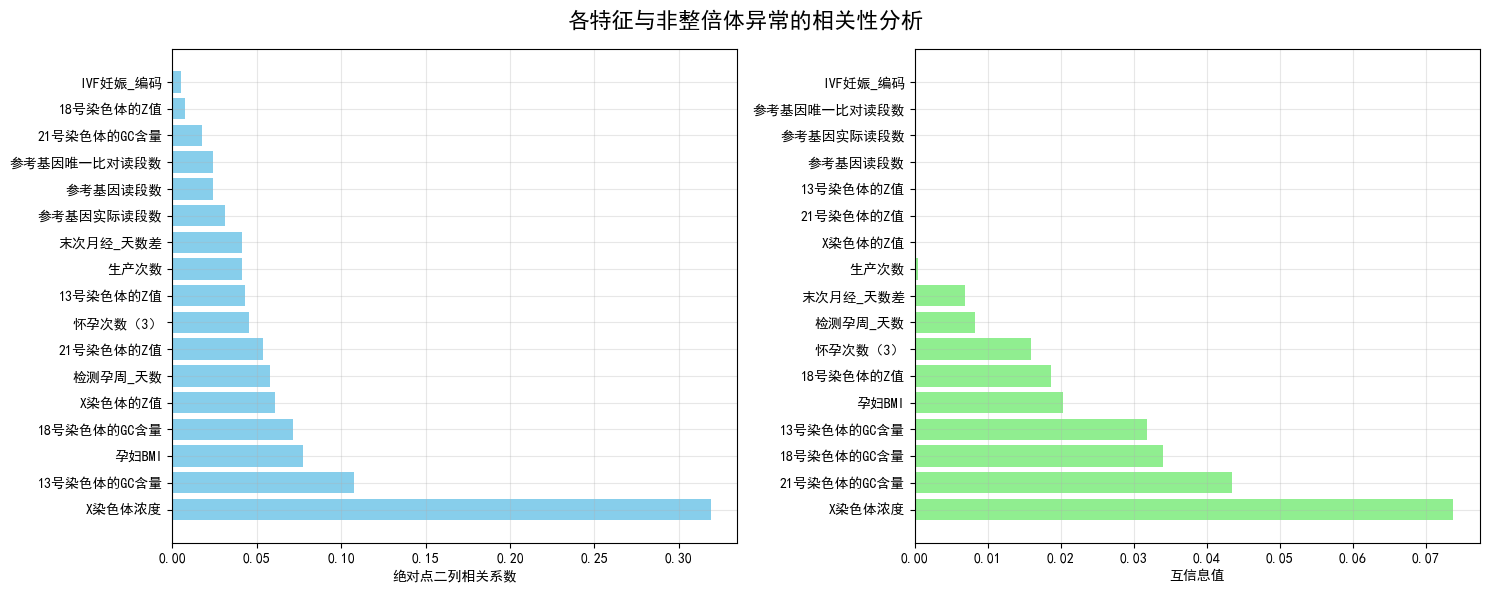


统计显著性分析
显著相关的特征数量 (p < 0.05): 2
不显著相关的特征数量 (p ≥ 0.05): 15

显著相关的特征:
  X染色体浓度: r = -0.3188, p = 0.0000
  13号染色体的GC含量: r = 0.1073, p = 0.0082


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr, spearmanr
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
df = pd.read_excel("附件_降维_XX.xlsx")

# 选择要分析的特征列
features_to_analyze = [
    "孕妇BMI", "13号染色体的Z值", "18号染色体的Z值", "21号染色体的Z值", 
    "X染色体的Z值", "X染色体浓度", "13号染色体的GC含量", 
    "18号染色体的GC含量", "21号染色体的GC含量", "参考基因读段数", 
    "参考基因实际读段数", "参考基因唯一比对读段数", "检测孕周_天数",
    "IVF妊娠_编码", "末次月经_天数差", "怀孕次数（3）", "生产次数"
]

target = "非整倍体异常"

# 1. 计算点二列相关系数（连续特征与二分类目标）
correlation_results = []
for feature in features_to_analyze:
    if feature in df.columns:
        # 移除缺失值
        valid_data = df[[feature, target]].dropna()
        if len(valid_data) > 10:  # 确保有足够的数据点
            corr, p_value = pointbiserialr(valid_data[feature], valid_data[target])
            correlation_results.append({
                '特征': feature,
                '点二列相关系数': corr,
                'P值': p_value,
                '绝对值': abs(corr),
                '样本数': len(valid_data)
            })

# 创建相关性DataFrame并排序
corr_df = pd.DataFrame(correlation_results)
corr_df = corr_df.sort_values('绝对值', ascending=False)

print("=" * 60)
print("各特征与'非整倍体异常'的点二列相关性分析")
print("=" * 60)
print(corr_df.round(4))
print(f"\n平均绝对相关系数: {corr_df['绝对值'].mean():.4f}")
print(f"最大相关系数: {corr_df['点二列相关系数'].abs().max():.4f}")

# 2. 计算互信息（非线性关系）
print("\n" + "=" * 60)
print("互信息分析（非线性关系）")
print("=" * 60)

# 准备数据
X_mi = df[features_to_analyze].fillna(df[features_to_analyze].median())
y_mi = df[target].values

# 计算互信息
mi_scores = mutual_info_classif(X_mi, y_mi, random_state=42)
mi_df = pd.DataFrame({
    '特征': features_to_analyze,
    '互信息': mi_scores
}).sort_values('互信息', ascending=False)

print(mi_df.round(4))
print(f"\n平均互信息: {mi_df['互信息'].mean():.4f}")
print(f"最大互信息: {mi_df['互信息'].max():.4f}")

# 3. 可视化相关性结果
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 3.1 点二列相关系数条形图
axes[0].barh(range(len(corr_df)), corr_df['点二列相关系数'].abs(), color='skyblue')
axes[0].set_yticks(range(len(corr_df)))
axes[0].set_yticklabels(corr_df['特征'])
axes[0].set_xlabel('绝对点二列相关系数')
axes[0].grid(True, alpha=0.3)

# 3.2 互信息条形图
axes[1].barh(range(len(mi_df)), mi_df['互信息'], color='lightgreen')
axes[1].set_yticks(range(len(mi_df)))
axes[1].set_yticklabels(mi_df['特征'])
axes[1].set_xlabel('互信息值')
axes[1].grid(True, alpha=0.3)

plt.suptitle('各特征与非整倍体异常的相关性分析', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('异常相关性分析.png', format="png", dpi=400, bbox_inches='tight')
plt.show()

# 4. 统计显著性分析
print("\n" + "=" * 60)
print("统计显著性分析")
print("=" * 60)

significant_features = corr_df[corr_df['P值'] < 0.05]
non_significant_features = corr_df[corr_df['P值'] >= 0.05]

print(f"显著相关的特征数量 (p < 0.05): {len(significant_features)}")
print(f"不显著相关的特征数量 (p ≥ 0.05): {len(non_significant_features)}")

if len(significant_features) > 0:
    print("\n显著相关的特征:")
    for _, row in significant_features.iterrows():
        print(f"  {row['特征']}: r = {row['点二列相关系数']:.4f}, p = {row['P值']:.4f}")


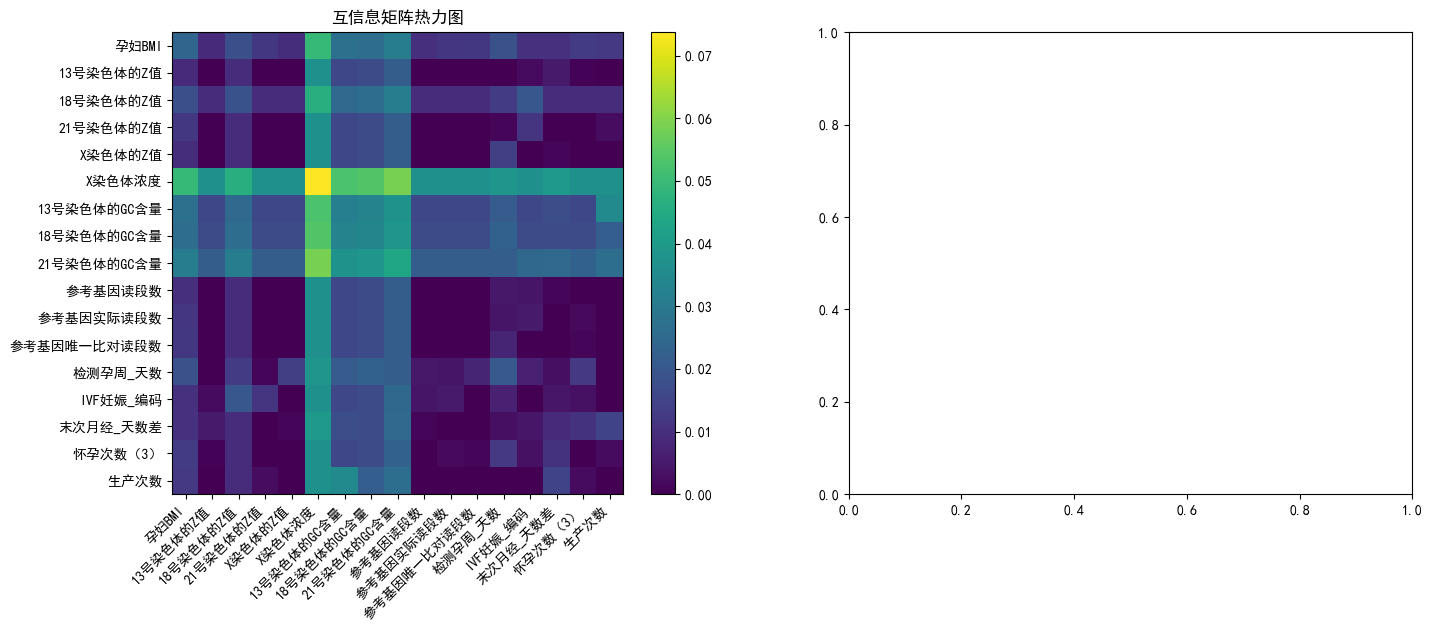

In [3]:
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
from scipy.cluster import hierarchy

def calculate_mi_matrix(X, y):
    n_features = X.shape[1]
    mi_matrix = np.zeros((n_features, n_features))
    
    for i in range(n_features):
        for j in range(i, n_features):
            if i == j:
                # 特征与目标的互信息
                mi_matrix[i, j] = mutual_info_classif(X.iloc[:, i:i+1], y)[0]
            else:
                # 特征间的互信息
                mi_ij = mutual_info_classif(X.iloc[:, [i, j]], y)
                mi_matrix[i, j] = mi_ij.mean()
                mi_matrix[j, i] = mi_ij.mean()
    
    return mi_matrix

X_mi = df[features_to_analyze].fillna(df[features_to_analyze].median())
mi_matrix = calculate_mi_matrix(X_mi, y_mi)

# 聚类热力图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 热力图
im = ax1.imshow(mi_matrix, cmap='viridis', aspect='auto')
ax1.set_xticks(range(len(features_to_analyze)))
ax1.set_yticks(range(len(features_to_analyze)))
ax1.set_xticklabels(features_to_analyze, rotation=45, ha='right')
ax1.set_yticklabels(features_to_analyze)
ax1.set_title('互信息矩阵热力图')
plt.colorbar(im, ax=ax1)
